# Locating startups and shutdowns
In the initial exploration, we used a quick-and-dirty method of removing cold starts by filtering out 1) load near zero and 2) the bottom X percent of load. That was good enough for a proof of concept, but unsuitable for plants with low capacity factors or wide operational power bands.

In this notebook I explore different methods of identifying cold starts that leverage the time series aspect of the data.

In [1]:
%load_ext autoreload
%autoreload 2

In [26]:
from src.data.load_dataset import load_epacems
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [3]:
idx = pd.IndexSlice

In [4]:
# all states, 1 year, all columns
cems = load_epacems(states=None, years=[2019], columns=None, engine='pandas')

In [5]:
cems.loc[:, 'unitid'] = cems.loc[:, 'unitid'].astype('category', copy=False) # save memory

In [6]:
cems.sample(3)

,plant_id_eia,unitid,operating_datetime_utc,operating_time_hours,gross_load_mw,steam_load_1000_lbs,so2_mass_lbs,so2_mass_measurement_code,nox_rate_lbs_mmbtu,nox_rate_measurement_code,nox_mass_lbs,nox_mass_measurement_code,co2_mass_tons,co2_mass_measurement_code,heat_content_mmbtu,facility_id,unit_id_epa,year,state
1019038,6009,2,2019-07-29 04:00:00+00:00,1.0,227.0,NaN,1318.400024,Measured,0.293,Measured,757.200012,Measured,271.0,Measured,2584.300049,783,2676,2019,AR
19884919,2716,7,2019-12-23 12:00:00+00:00,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.000000,524,88327,2019,NC
19534648,56249,ES4-A,2019-08-27 21:00:00+00:00,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.000000,8103,89589,2019,NC


## First, what is a good primary key for this dataset?
* not null
* unique

In [7]:
cems.isna().any()

plant_id_eia                 False
unitid                       False
operating_datetime_utc       False
operating_time_hours          True
gross_load_mw                False
steam_load_1000_lbs           True
so2_mass_lbs                  True
so2_mass_measurement_code     True
nox_rate_lbs_mmbtu            True
nox_rate_measurement_code     True
nox_mass_lbs                  True
nox_mass_measurement_code     True
co2_mass_tons                 True
co2_mass_measurement_code     True
heat_content_mmbtu           False
facility_id                  False
unit_id_epa                  False
year                         False
state                        False
dtype: bool

In [8]:
n_uniques = cems.groupby('operating_datetime_utc').nunique()

In [9]:
counts = cems.groupby('operating_datetime_utc').count()

In [10]:
# check they are equal over all time
n_uniques.eq(counts.max(axis=1), axis=0).all()

plant_id_eia                 False
unitid                       False
operating_time_hours         False
gross_load_mw                False
steam_load_1000_lbs          False
so2_mass_lbs                 False
so2_mass_measurement_code    False
nox_rate_lbs_mmbtu           False
nox_rate_measurement_code    False
nox_mass_lbs                 False
nox_mass_measurement_code    False
co2_mass_tons                False
co2_mass_measurement_code    False
heat_content_mmbtu           False
facility_id                  False
unit_id_epa                   True
year                         False
state                        False
dtype: bool

Well that makes sense. I'll use the EPA id for the EPA dataset.

In [11]:
cems.set_index(['unit_id_epa', 'operating_datetime_utc'], drop=True, inplace=True, verify_integrity=True)

In [12]:
cems.sort_values(by=['unit_id_epa', 'operating_datetime_utc'], inplace=True)

## Viz a few plant months

In [13]:
units = cems.groupby(level=['unit_id_epa'])

In [14]:
rng = np.random.default_rng(seed=2)

In [15]:
UNIT = rng.choice(cems.index.levels[0])
UNIT

90035

In [16]:
unit = cems.loc[idx[UNIT,:], 'gross_load_mw'].to_frame()
unit.index = unit.index.droplevel(0)

<AxesSubplot:title={'center':'unit_id_epa: 90035'}, xlabel='operating_datetime_utc', ylabel='gross_load_mw'>

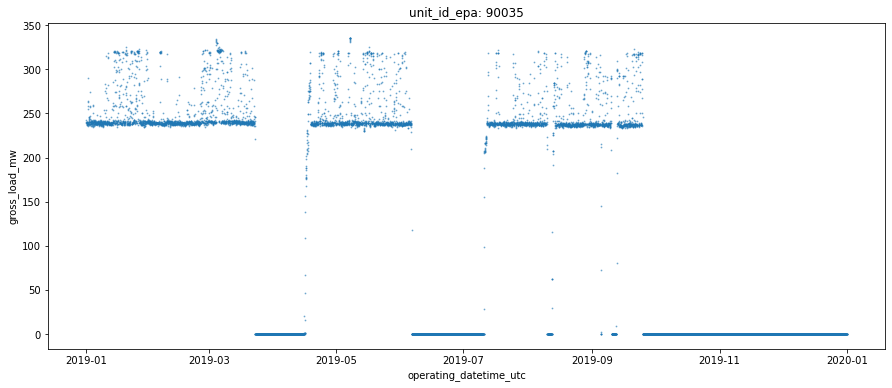

In [17]:
unit.reset_index().plot.scatter(x='operating_datetime_utc', y='gross_load_mw', figsize=(15,6), marker='.', alpha=0.5, s=3, title=f'unit_id_epa: {UNIT}')

An aside: UNIT=90667 shows a curved max capacity - thermally limited in the summer. Also, the two biggest outages are in the spring/fall 'shoulders' when demand is lowest. A good plant for demonstrating these phenomena.

In [18]:
MONTH = rng.choice(range(1,13))
MONTH

4

In [19]:
START = f'2019-{MONTH}-01'
END = f'2019-{MONTH + 1}-01' if MONTH < 12 else '2019-12-31'
print(START, END)

2019-4-01 2019-5-01


In [20]:
row_slice = idx[UNIT, START:END]

<AxesSubplot:xlabel='operating_datetime_utc'>

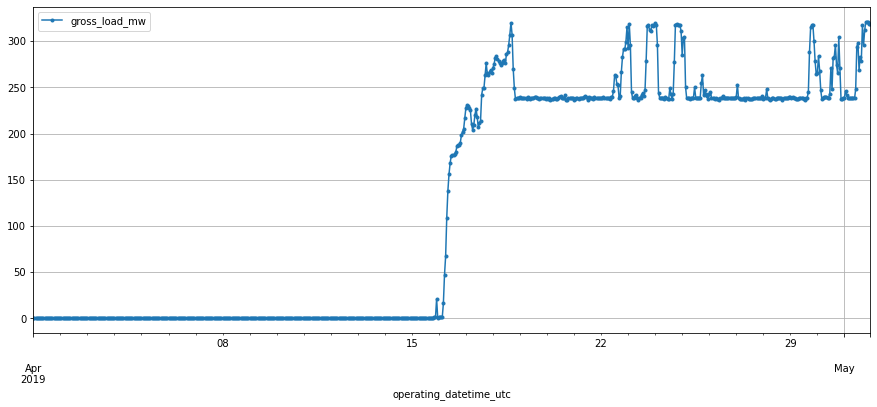

In [21]:
unit[START:END].plot(marker='.', figsize=(15,6), grid=True)

## Check distribution of near-zero values - can I use equality to zero or is there noise?
Maybe, because values are discretized. But there are a suspiciously high number of 1s, so might have to threshold anyway.

<AxesSubplot:>

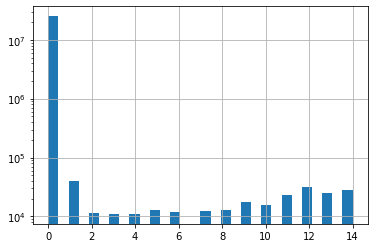

In [29]:
cems.loc[cems['gross_load_mw'] < 15, 'gross_load_mw'].hist(bins=30, log=True)

## Use a digital edge finder to extract start/stops

In [23]:
# map values below a threshold to 0, above to 1
# this needs to be normalized by plant size - see unit_id_epa = 90186 for <10MW peaker
THRESH = 1.5
#binarized = cems['gross_load_mw'] > thresh

In [24]:
diff = unit.gt(THRESH).astype(np.int8).diff().squeeze()
starts = unit[diff.shift(-1) == 1] # shift(-1) to prevent off-by-one error
stops = unit[diff == -1]

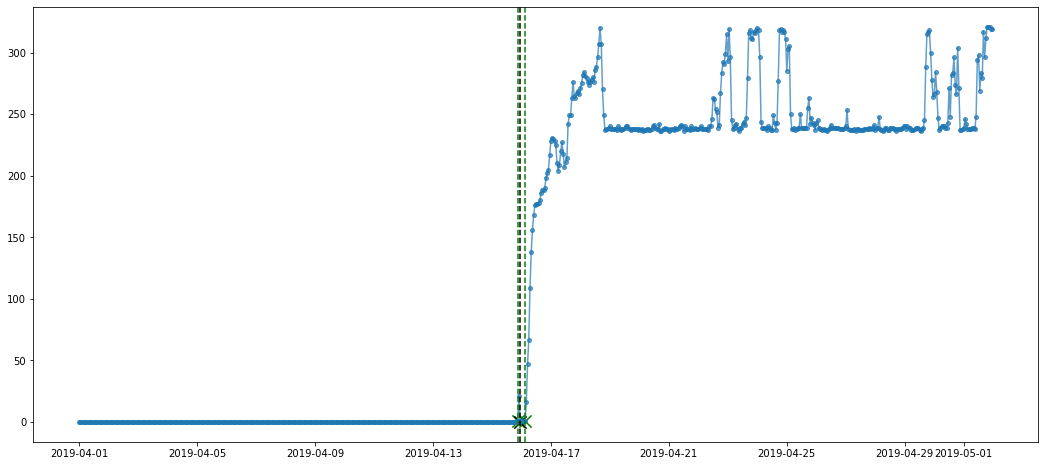

In [27]:
fig, ax = plt.subplots(figsize=(18,8))
ax.scatter(starts[START:END].index, starts[START:END], c="g", s=150, marker='x')
ax.scatter(stops[START:END].index, stops[START:END], c="k", s=150, marker='x')
ax.plot(unit[START:END].index, unit[START:END].values, marker='.', markersize=8, alpha=0.7)
for start in starts[START:END].index:
    ax.axvline(start, c='g', ls='--')
for stop in stops[START:END].index:
    ax.axvline(stop, c='k', ls='--')

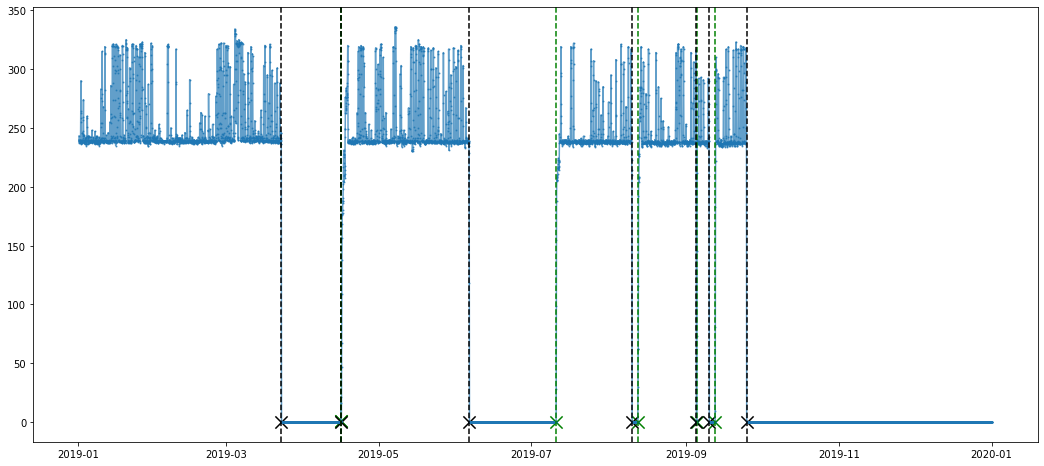

In [28]:
fig, ax = plt.subplots(figsize=(18,8))
ax.scatter(starts.index, starts, c="g", s=150, marker='x')
ax.scatter(stops.index, stops, c="k", s=150, marker='x')
ax.plot(unit.index, unit.values, marker='.', markersize=2, alpha=0.7)
for start in starts.index:
    ax.axvline(start, c='g', ls='--')
for stop in stops.index:
    ax.axvline(stop, c='k', ls='--')